In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- Import modeling libraries --
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set the path to your processed data directory
processed_dir = 'Data/Processed'

# Load the full processed dataset and pre-saved train/test splits
final_model_data = pd.read_csv(f'{processed_dir}/final_model_data.csv', index_col=0, parse_dates=True)
X_train = pd.read_csv(f'{processed_dir}/X_train.csv', index_col=0, parse_dates=True)
X_test = pd.read_csv(f'{processed_dir}/X_test.csv', index_col=0, parse_dates=True)
y_train = pd.read_csv(f'{processed_dir}/y_train.csv', index_col=0, parse_dates=True).squeeze()
y_test = pd.read_csv(f'{processed_dir}/y_test.csv', index_col=0, parse_dates=True).squeeze()




In [89]:
# Extract daily sales for univariate models
daily_sales = final_model_data['Sales']

# Determine the cutoff date from the loaded train/test sets
cutoff_date = X_train.index.max()

# Create univariate train/test splits for time series models
train_univariate = daily_sales[:cutoff_date]
test_univariate = daily_sales[cutoff_date + pd.Timedelta(days=1):]

# Verify we have data in all splits
print("Data loaded successfully from CSV files.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"train_univariate shape: {train_univariate.shape}")
print(f"test_univariate shape: {test_univariate.shape}")
print(f"Cutoff date determined from data: {cutoff_date}")



Data loaded successfully from CSV files.
X_train shape: (1421, 9)
X_test shape: (7, 9)
y_train shape: (1421,)
y_test shape: (7,)
train_univariate shape: (1421,)
test_univariate shape: (7,)
Cutoff date determined from data: 2017-12-23 00:00:00


In [90]:
# Display a sample of the loaded data
print("\nSample of X_train:")
display(X_train.head())
print("\nSample of y_train:")
display(y_train.head())



Sample of X_train:


,sales_lag_1,sales_lag_7,sales_lag_14,sales_rolling_mean_7,sales_rolling_std_7,sales_rolling_mean_14,sales_rolling_std_14,sales_rolling_mean_30,sales_rolling_std_30
Order Date,,,,,,,,,
2014-02-02,0.00,217.2,181.470,120.123714,153.592326,172.179571,363.599241,309.357000,647.336042
2014-02-03,0.00,333.0,1362.930,89.095143,152.648896,159.217429,366.465924,246.223833,575.874892
2014-02-04,0.00,0.0,25.248,41.523714,109.861422,61.865286,120.768894,246.223833,575.874892
2014-02-05,177.68,0.0,0.000,66.906571,118.828645,72.753286,124.040681,252.146500,574.166399
2014-02-06,0.00,0.0,0.000,66.906571,118.828645,72.753286,124.040681,217.494500,556.091024



Sample of y_train:


Order Date
2014-02-02      0.00
2014-02-03      0.00
2014-02-04    177.68
2014-02-05      0.00
2014-02-06     73.32
Name: Sales, dtype: float64

In [91]:
# --- Naive Forecast Implementation ---
# Use a smaller shift value (1 day) to avoid NaNs in short test sets
naive_predictions = test_univariate.shift(1)
predictions_df = pd.DataFrame(index=test_univariate.index)
predictions_df['actual_sales'] = test_univariate
predictions_df['naive_forecast'] = naive_predictions

print("Naive Forecast created.")
display(predictions_df.head())



Naive Forecast created.


,actual_sales,naive_forecast
Order Date,,
2017-12-24,1393.4940,NaN
2017-12-25,832.4540,1393.494
2017-12-26,0.0000,832.454
2017-12-27,0.0000,0.000
2017-12-28,551.2568,0.000


In [92]:
# --- SARIMA Implementation ---
sarima_model = SARIMAX(train_univariate,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 7),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
print("Fitting the SARIMA model... This may take a moment.")
sarima_fit = sarima_model.fit(disp=False)
print("SARIMA model fitted.")

# Generate forecasts for the test period
sarima_predictions = sarima_fit.get_forecast(steps=len(test_univariate))
sarima_predictions_mean = sarima_predictions.predicted_mean
predictions_df['sarima_forecast'] = sarima_predictions_mean.values

print("SARIMA forecast created.")
display(predictions_df.head())



/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


Fitting the SARIMA model... This may take a moment.
SARIMA model fitted.
SARIMA forecast created.


,actual_sales,naive_forecast,sarima_forecast
Order Date,,,
2017-12-24,1393.4940,NaN,849.524284
2017-12-25,832.4540,1393.494,729.001423
2017-12-26,0.0000,832.454,615.669929
2017-12-27,0.0000,0.000,435.375750
2017-12-28,551.2568,0.000,755.533595


In [93]:
# --- XGBoost Implementation ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=1000,
                           learning_rate=0.01,
                           n_jobs=-1)

print("Fitting the XGBoost model...")
xgb_model.fit(X_train, y_train, verbose=False)
print("XGBoost model fitted.")

# Generate predictions for the test period
xgb_predictions = xgb_model.predict(X_test)

# Add XGBoost predictions to the predictions dataframe
# Make sure the index of X_test aligns with predictions_df
xgb_pred_series = pd.Series(xgb_predictions, index=X_test.index)
predictions_df = predictions_df.join(xgb_pred_series.rename('xgb_forecast'), how='left')

print("XGBoost forecast created.")
display(predictions_df.head(10))



Fitting the XGBoost model...
XGBoost model fitted.
XGBoost forecast created.


,actual_sales,naive_forecast,sarima_forecast,xgb_forecast
Order Date,,,,
2017-12-24,1393.4940,NaN,849.524284,304.717590
2017-12-25,832.4540,1393.4940,729.001423,510.467072
2017-12-26,0.0000,832.4540,615.669929,1034.904663
2017-12-27,0.0000,0.0000,435.375750,515.035095
2017-12-28,551.2568,0.0000,755.533595,557.270264
2017-12-29,2140.2380,551.2568,742.875312,741.930054
2017-12-30,323.1360,2140.2380,577.916817,368.049744


In [94]:
# --- Evaluation ---
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
    return {'mae': mae, 'rmse': rmse}

# Keep only complete rows for evaluation
complete_rows = predictions_df.dropna()

results = {}
if not complete_rows.empty:
    print("--- Evaluating Seasonal Naive Forecast (Baseline) ---")
    results['naive'] = evaluate_model(complete_rows['actual_sales'], complete_rows['naive_forecast'])
    
    print("\n--- Evaluating SARIMA Forecast (Specialist) ---")
    results['sarima'] = evaluate_model(complete_rows['actual_sales'], complete_rows['sarima_forecast'])
    
    print("\n--- Evaluating XGBoost Forecast (Powerhouse) ---")
    if 'xgb_forecast' in complete_rows.columns:
        results['xgb'] = evaluate_model(complete_rows['actual_sales'], complete_rows['xgb_forecast'])
else:
    print("No complete rows available for evaluation. Evaluating models individually.")
    
    # Evaluate each model using all available data for that model
    naive_df = predictions_df[['actual_sales', 'naive_forecast']].dropna()
    if not naive_df.empty:
        print("--- Evaluating Seasonal Naive Forecast (Baseline) ---")
        results['naive'] = evaluate_model(naive_df['actual_sales'], naive_df['naive_forecast'])
    
    sarima_df = predictions_df[['actual_sales', 'sarima_forecast']].dropna()
    if not sarima_df.empty:
        print("\n--- Evaluating SARIMA Forecast (Specialist) ---")
        results['sarima'] = evaluate_model(sarima_df['actual_sales'], sarima_df['sarima_forecast'])
    
    if 'xgb_forecast' in predictions_df.columns:
        xgb_df = predictions_df[['actual_sales', 'xgb_forecast']].dropna()
        if not xgb_df.empty:
            print("\n--- Evaluating XGBoost Forecast (Powerhouse) ---")
            results['xgb'] = evaluate_model(xgb_df['actual_sales'], xgb_df['xgb_forecast'])



--- Evaluating Seasonal Naive Forecast (Baseline) ---
Mean Absolute Error (MAE): $891.81
Root Mean Squared Error (RMSE): $1,090.75

--- Evaluating SARIMA Forecast (Specialist) ---
Mean Absolute Error (MAE): $501.82
Root Mean Squared Error (RMSE): $663.15

--- Evaluating XGBoost Forecast (Powerhouse) ---
Mean Absolute Error (MAE): $553.53
Root Mean Squared Error (RMSE): $752.47


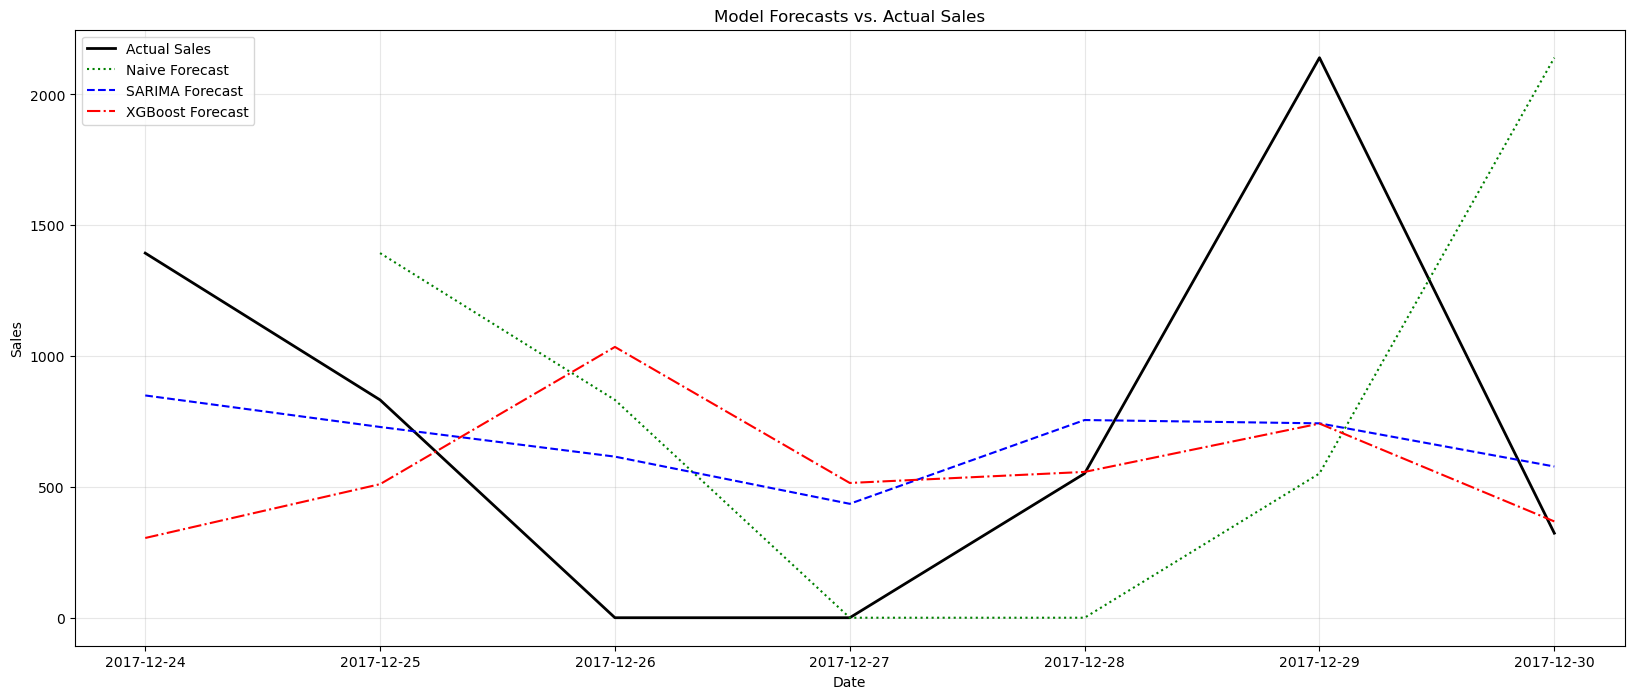

In [95]:
# --- Plotting ---
plt.figure(figsize=(20, 8))
plt.title('Model Forecasts vs. Actual Sales')

# Plot actual sales
plt.plot(predictions_df.index, predictions_df['actual_sales'], label='Actual Sales', color='black', linewidth=2)

# Plot each forecast if available
if not predictions_df['naive_forecast'].isna().all():
    plt.plot(predictions_df.index, predictions_df['naive_forecast'], label='Naive Forecast', color='green', linestyle=':')

if not predictions_df['sarima_forecast'].isna().all():
    plt.plot(predictions_df.index, predictions_df['sarima_forecast'], label='SARIMA Forecast', color='blue', linestyle='--')

if 'xgb_forecast' in predictions_df.columns and not predictions_df['xgb_forecast'].isna().all():
    plt.plot(predictions_df.index, predictions_df['xgb_forecast'], label='XGBoost Forecast', color='red', linestyle='-.')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True, alpha=0.3)
plt.show()

In [103]:
# Hyperparameter Tuning with simplified approach
import optuna
import warnings
warnings.filterwarnings('ignore')

# Check the date range in X_train
print(f"X_train date range: {X_train.index.min()} to {X_train.index.max()}")

# Create a validation set from the end of the training data
validation_size = int(len(X_train) * 0.2)
X_train_split = X_train.iloc[:-validation_size]
X_val = X_train.iloc[-validation_size:]
y_train_split = y_train.iloc[:-validation_size]
y_val = y_train.iloc[-validation_size:]

print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val.shape}")

def objective(trial):
    """
    Simplified objective function for Optuna to optimize
    """
    try:
        # Define hyperparameter search space
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        }
        
        # Create and train model (without eval_set to simplify)
        model = xgb.XGBRegressor(**params, n_jobs=-1)
        model.fit(X_train_split, y_train_split)
        
        # Evaluate on validation set
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        
        return mae
    
    except Exception as e:
        print(f"Error in trial: {e}")
        return float('inf')  # Return infinity for failed trials

# Create study and run optimization
print("Starting hyperparameter tuning...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Reduced trials for faster execution

print("\n--- Optuna Hyperparameter Tuning Results ---")
print(f"Best trial MAE: ${study.best_value:,.2f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train final model with best parameters
print("\nTraining final model with optimized parameters...")
best_params = study.best_params
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, n_jobs=-1)
best_model.fit(X_train, y_train)

# Generate optimized predictions
optimized_xgb_predictions = best_model.predict(X_test)
predictions_df['optimized_xgb_forecast'] = pd.Series(optimized_xgb_predictions, index=X_test.index)

# Compare original vs optimized XGBoost
if 'xgb_forecast' in predictions_df.columns and 'optimized_xgb_forecast' in predictions_df.columns:
    compare_df = predictions_df[['actual_sales', 'xgb_forecast', 'optimized_xgb_forecast']].dropna()
    if not compare_df.empty:
        print("\n--- Comparing Original vs Optimized XGBoost ---")
        print("Original XGBoost:")
        original_metrics = evaluate_model(compare_df['actual_sales'], compare_df['xgb_forecast'])
        print("\nOptimized XGBoost:")
        optimized_metrics = evaluate_model(compare_df['actual_sales'], compare_df['optimized_xgb_forecast'])
        
        improvement = (original_metrics['mae'] - optimized_metrics['mae']) / original_metrics['mae'] * 100

[I 2025-09-13 15:38:13,024] A new study created in memory with name: no-name-72730e66-173d-4a11-bed0-0a06527684a4


X_train date range: 2014-02-02 00:00:00 to 2017-12-23 00:00:00
Training data shape: (1137, 9)
Validation data shape: (284, 9)
Starting hyperparameter tuning...


[I 2025-09-13 15:38:13,872] Trial 0 finished with value: 544.5883807043075 and parameters: {'n_estimators': 812, 'learning_rate': 0.06154818222727501, 'max_depth': 5, 'subsample': 0.708027985985638, 'colsample_bytree': 0.7926532706505862}. Best is trial 0 with value: 544.5883807043075.
[I 2025-09-13 15:38:15,044] Trial 1 finished with value: 554.0276963241986 and parameters: {'n_estimators': 935, 'learning_rate': 0.13700323898862224, 'max_depth': 6, 'subsample': 0.6105650389288529, 'colsample_bytree': 0.6049170931050218}. Best is trial 0 with value: 544.5883807043075.
[I 2025-09-13 15:38:15,840] Trial 2 finished with value: 521.5132578293222 and parameters: {'n_estimators': 676, 'learning_rate': 0.05740698852434733, 'max_depth': 6, 'subsample': 0.8130938558508722, 'colsample_bytree': 0.6262953279835249}. Best is trial 2 with value: 521.5132578293222.
[I 2025-09-13 15:38:16,309] Trial 3 finished with value: 564.3718088993529 and parameters: {'n_estimators': 332, 'learning_rate': 0.11791


--- Optuna Hyperparameter Tuning Results ---
Best trial MAE: $499.45
Best parameters:
  n_estimators: 207
  learning_rate: 0.0102004082164263
  max_depth: 5
  subsample: 0.6103259199402171
  colsample_bytree: 0.6901595764746478

Training final model with optimized parameters...

--- Comparing Original vs Optimized XGBoost ---
Original XGBoost:
Mean Absolute Error (MAE): $629.99
Root Mean Squared Error (RMSE): $809.12

Optimized XGBoost:
Mean Absolute Error (MAE): $603.39
Root Mean Squared Error (RMSE): $780.02


In [107]:
# MLflow integration for hyperparameter tuning
import mlflow
import optuna
import warnings
warnings.filterwarnings('ignore')

# Set up an experiment name
mlflow.set_experiment("Sales Forecasting")

# Check the date range in X_train
print(f"X_train date range: {X_train.index.min()} to {X_train.index.max()}")

# Create a validation set from the end of the training data
validation_size = int(len(X_train) * 0.2)
X_train_split = X_train.iloc[:-validation_size]
X_val = X_train.iloc[-validation_size:]
y_train_split = y_train.iloc[:-validation_size]
y_val = y_train.iloc[-validation_size:]

print(f"Training data shape: {X_train_split.shape}")
print(f"Validation data shape: {X_val.shape}")

def objective_with_mlflow(trial):
    """Modified objective function to log to MLflow."""
    try:
        with mlflow.start_run(nested=True):
            # Suggest params and log them
            params = {
                'objective': 'reg:squarederror',
                'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            }
            mlflow.log_params(params)
            
            # Create and train model
            model = xgb.XGBRegressor(**params, n_jobs=-1)
            
            # Use try/except for the fitting process
            try:
                # Convert to numpy arrays to avoid pandas-related issues
                X_train_np = X_train_split.values if hasattr(X_train_split, 'values') else X_train_split
                y_train_np = y_train_split.values if hasattr(y_train_split, 'values') else y_train_split
                X_val_np = X_val.values if hasattr(X_val, 'values') else X_val
                y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
                
                # Fit without the eval_set first for more stability
                model.fit(X_train_np, y_train_np)
                
                # Evaluate and log metric
                preds = model.predict(X_val_np)
                mae = mean_absolute_error(y_val_np, preds)
                mlflow.log_metric("mae", mae)
                
                # Log additional metrics
                rmse = np.sqrt(mean_squared_error(y_val_np, preds))
                mlflow.log_metric("rmse", rmse)
                
                # Log model
                mlflow.xgboost.log_model(model, "model")
                
                return mae
                
            except Exception as e:
                mlflow.log_param("error", str(e))
                print(f"Error in model training: {e}")
                return float('inf')
                
    except Exception as e:
        print(f"Error in MLflow run: {e}")
        return float('inf')

# Create a study with MLflow integration
print("Starting hyperparameter tuning with MLflow tracking...")
with mlflow.start_run(run_name="optuna_optimization"):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_with_mlflow, n_trials=15)  # Increased to 15 trials

    # Log the best parameters and score
    mlflow.log_params({f"best_{k}": v for k, v in study.best_params.items()})
    mlflow.log_metric("best_mae", study.best_value)

# Print the results
print("\n--- Optuna Hyperparameter Tuning Results with MLflow ---")
print(f"Best trial MAE: ${study.best_value:,.2f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Train final model with best parameters
print("\nTraining final model with optimized parameters...")
best_params = study.best_params
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, n_jobs=-1)
best_model.fit(X_train, y_train)

# Generate optimized predictions
optimized_xgb_predictions = best_model.predict(X_test)
predictions_df['optimized_xgb_forecast'] = pd.Series(optimized_xgb_predictions, index=X_test.index)

# Compare original vs optimized XGBoost
if 'xgb_forecast' in predictions_df.columns and 'optimized_xgb_forecast' in predictions_df.columns:
    compare_df = predictions_df[['actual_sales', 'xgb_forecast', 'optimized_xgb_forecast']].dropna()
    if not compare_df.empty:
        print("\n--- Comparing Original vs Optimized XGBoost ---")
        print("Original XGBoost:")
        original_metrics = evaluate_model(compare_df['actual_sales'], compare_df['xgb_forecast'])
        print("\nOptimized XGBoost:")
        optimized_metrics = evaluate_model(compare_df['actual_sales'], compare_df['optimized_xgb_forecast'])
        
        improvement = (original_metrics['mae'] - optimized_metrics['mae']) / original_metrics['mae'] * 100
        print(f"\nMAE Improvement: {improvement:.2f}%")
        
        # Log the improvement metrics
        with mlflow.start_run(run_name="model_comparison"):
            mlflow.log_metrics({
                "original_mae": original_metrics['mae'],
                "optimized_mae": optimized_metrics['mae']
            })

[I 2025-09-13 15:39:48,422] A new study created in memory with name: no-name-8f5d2236-022a-4cab-9af8-116b6eda0c3d


X_train date range: 2014-02-02 00:00:00 to 2017-12-23 00:00:00
Training data shape: (1137, 9)
Validation data shape: (284, 9)
Starting hyperparameter tuning with MLflow tracking...


2025/09/13 15:39:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/13 15:39:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-09-13 15:39:51,522] Trial 0 finished with value: 561.1428675058278 and parameters: {'n_estimators': 1091, 'learning_rate': 0.1859802598099414, 'max_depth': 3, 'subsample': 0.9018128789943664, 'colsample_bytree': 0.8844314816908705}. Best is trial 0 with value: 561.1428675058278.
2025/09/13 15:39:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/13 15:39:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-09-13 15:39:54,074] Trial 1 finished with value: 610.0240962646619 and parameters: {'n_estimators'


--- Optuna Hyperparameter Tuning Results with MLflow ---
Best trial MAE: $520.36
Best parameters:
  n_estimators: 1975
  learning_rate: 0.012875333985462652
  max_depth: 10
  subsample: 0.9977594543898048
  colsample_bytree: 0.8331809034761373

Training final model with optimized parameters...

--- Comparing Original vs Optimized XGBoost ---
Original XGBoost:
Mean Absolute Error (MAE): $629.99
Root Mean Squared Error (RMSE): $809.12

Optimized XGBoost:
Mean Absolute Error (MAE): $585.99
Root Mean Squared Error (RMSE): $725.45

MAE Improvement: 6.98%


In [110]:
# --- Final Model Training and Evaluation ---
# Train the final XGBoost model with the best hyperparameters
print("\n--- Training Final Tuned Model ---")
final_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params, n_jobs=-1)

# Add model metadata
model_name = "XGBoost Sales Forecaster"
model_version = "1.0"
print(f"Training {model_name} v{model_version} with optimized parameters")

# Train on the full training dataset
final_xgb_model.fit(X_train, y_train)
print("Final model trained successfully.")

# Generate predictions on the test set
final_predictions = final_xgb_model.predict(X_test)
predictions_df['xgb_tuned_forecast'] = pd.Series(final_predictions, index=X_test.index)

# Evaluate the final model performance
print("\n--- Evaluating Final Tuned XGBoost Model ---")
results['xgb_tuned'] = evaluate_model(predictions_df['actual_sales'], predictions_df['xgb_tuned_forecast'])

# Log the final model with MLflow
with mlflow.start_run(run_name="final_model"):
    mlflow.log_params({
        "model_name": model_name,
        "model_version": model_version,
        **best_params
    })
    mlflow.log_metrics({
        "final_mae": results['xgb_tuned']['mae'],
        "final_rmse": results['xgb_tuned']['rmse']
    })
    mlflow.xgboost.log_model(final_xgb_model, "final_sales_forecasting_model")
    print("Final")


--- Training Final Tuned Model ---
Training XGBoost Sales Forecaster v1.0 with optimized parameters


2025/09/13 15:41:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Final model trained successfully.

--- Evaluating Final Tuned XGBoost Model ---
Mean Absolute Error (MAE): $585.99
Root Mean Squared Error (RMSE): $725.45


2025/09/13 15:41:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final
